In [73]:
using NBInclude
@nbinclude("functions.ipynb")

All function imported


In [99]:
#setup
x_dim = 784
m = 140
k = 20
epoch_to_load = 20 # Load the model 
tolerance = 1e-7; max_iter = 2000; out_toggle = 0
trials = 20
opt = Flux.Optimise.ADAM(.1);

In [75]:
_, _, decoder = load_model("trained_GNN/MNIST", epoch_to_load)
B = randn(784, 500)/sqrt(784)
z = randn(k) # ground code vector
F = dct(diagm(ones(x_dim)),2);

Loading model...Done


In [83]:
# generate "uniform" gapped incoherence
β_list = 0:.001:1
α_list = []
for β in β_list
    push!(α_list, subspace_incoherence(F, β * Flux.params(decoder)[3] + (1-β)*B) )
    
end

α_list_ideal = LinRange(α_list[1],α_list[end], 11)
index_list = []
for α_ideal in α_list_ideal
    temp = 0
    index = 0
    for i in 1:length(α_list)
        if abs(temp - α_ideal) > abs(α_list[i] - α_ideal)
            temp = α_list[i]
            index = i
        end
    end
    push!(index_list, index)
end
β_list = β_list[index_list]
α_list = α_list[index_list]

11-element Vector{Any}:
 0.8425311207118559
 0.8564657574318778
 0.870008300254838
 0.8834424388396847
 0.8974480408730462
 0.9109626371869723
 0.924134265427906
 0.9377956393070827
 0.951472073634627
 0.9652185775946865
 0.97879445746685

In [100]:
recovery_error_matrix = zeros(trials)
recon_error_matrix = zeros(trials)
for β in β_list
    recovery_error_list = []
    recon_error_list = []
    G = Chain(
        Dense(20, 500, relu, bias = false; init =(out,in) -> Flux.params(decoder)[1]),
        Dense(500, 500, relu, bias = false; init =(out,in) -> Flux.params(decoder)[2]),
        Dense(500, 784, identity, bias = false; init =(out,in) -> β * Flux.params(decoder)[3] + (1-β)*B),
    )   #setup the generative network 


    for trials in 1:trials
        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
        y = F_sub * G(z) # measurement vector using subsampled DCT matrix
  
        z_est = randn(k) #initialization for algorithm
        z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

        push!(recovery_error_list, relative_error(z, z_est))    
        push!(recon_error_list, relative_error(G(z), G(z_est)))
    end

    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
end

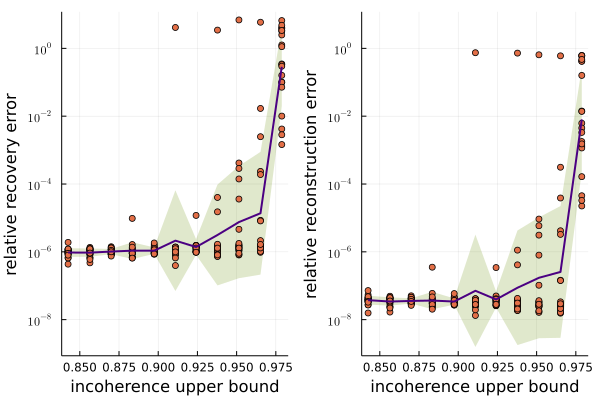

In [144]:
cs = palette([:red,  :orange, :green, :blue, :Indigo], 1000)

log_recovery_error_matrix = log10.(recovery_error_matrix[:, 2:end])
average_recov = mean(log_recovery_error_matrix, dims=1)'
std_recov = std(log_recovery_error_matrix, dims=1)'
plot(α_list, average_recov + std_recov, fillrange =  average_recov - std_recov, fillalpha = .2, c = cs[400], label = false,linecolor = invisible())
scatter!(kron(α_list',ones(trials,1))[:], log_recovery_error_matrix[:], label =:false)
p1 = plot!(α_list, average_recov, xlabel = "incoherence upper bound", ylabel = "relative recovery error", linewidth = 2, color = cs[1000], label =false)
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])



log_recon_error_matrix = log10.(recon_error_matrix[:, 2:end])
average_recon = mean(log_recon_error_matrix, dims=1)'
std_recon = std(log_recon_error_matrix, dims=1)'
plot(α_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = .2, c = cs[400], label = false, linecolor = invisible())
scatter!(kron(α_list',ones(trials,1))[:], log_recon_error_matrix[:], label =:false)
p2 = plot!(α_list, average_recon, xlabel = "incoherence upper bound", ylabel = "relative reconstruction error", linewidth = 2, color = cs[1000], label =false )
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])


plot(p1,p2,layout = 2, ylims = (minimum([ylims(p1)[1],ylims(p2)[1]]), maximum([ylims(p1)[2],ylims(p2)[2]]) ))



In [145]:
savefig("figures/Full_MNIST_error.pdf")
save("save_data/Full_MNIST_error.jld", "recovery error", recovery_error_matrix, "reconstruction error", recon_error_matrix, "α_list", α_list)